# Simple example of Grad-CAM

## Overview of Grad-CAM
![title](grad-cam_overview.png)

In [2]:
import math
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import Inception_resnet
from vgg_2 import vgg_16
import tensorflow.contrib.slim as slim
from tensorflow.python.framework import ops
from tensorflow.python.ops import gen_nn_ops

In [3]:
tf.VERSION

'1.14.0'

In [4]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [5]:
tf.set_random_seed(0)

In [6]:
def print_prob(prob, file_path):
    synset = [l.strip() for l in open(file_path).readlines()]
    #print(synset)
    pred = np.argsort(prob)[::-1]

    # Get top1 label
    top1 = synset[pred[0]]
    print("Top1: ", top1, prob[pred[0]])
    # Get top5 label
    #top5 = [(synset[pred[i]], prob[pred[i]]) for i in range(5)]
    #print("Top5: ", top5)
    return top1

In [7]:
def calc_cam(feature_map_Activations_value, grad_feature_map_Actvations_value, guided_backprop_grad_value):
    
    ##############################
    ###        grad-CAM        ###
    ##############################
    cam = np.zeros(feature_map_Activations_value.shape[0 : 2], dtype = np.float32)
    # Global average pooling
    weights_alpha = np.mean(grad_feature_map_Actvations_value, axis = (0, 1))
    # Passing through ReLU (weight_alpha, optional)
    weights_alpha = np.maximum(weights_alpha, 0)
    # Taking a weighted average
    for i, w in enumerate(weights_alpha):
        cam += w * feature_map_Activations_value[:, :, i]
    # Passing through ReLU
    cam_original = np.maximum(cam, 0)
    cam = np.maximum(cam, 0)
    # Normalize
    cam = cam / np.max(cam) # scale 0 to 1.0
    cam = cv2.resize(cam, (224,224))
    # Express as heatmap
    cam_heatmap = cv2.applyColorMap(np.uint8(255*cam), cv2.COLORMAP_JET)
    cam_heatmap = cv2.cvtColor(cam_heatmap, cv2.COLOR_BGR2RGB)
    
    
    ##############################
    ###     guided grad-CAM    ###
    ##############################
    # guided grad-CAM = guided backprop * grad-CAM
    # Normalize
    guided_backprop_grad_value -= np.min(guided_backprop_grad_value)
    guided_backprop_grad_value /= guided_backprop_grad_value.max()
    guided_backprop_grad_cam = np.dstack((
            guided_backprop_grad_value[:, :, 0] * cam,
            guided_backprop_grad_value[:, :, 1] * cam,
            guided_backprop_grad_value[:, :, 2] * cam,
        ))
    
    return cam_heatmap, guided_backprop_grad_value, guided_backprop_grad_cam, cam, cam_original

In [8]:
### SET PARAMETERS 
class_num = 4
class_txt =  './synset.txt'
latest_checkpoint = 'checkpoint/cl/reduced_model_test/201120_1_modified_2_2/280-21000'
# latest_checkpoint = 'checkpoint/inception_resnet_v2.ckpt'
layer_name = 'vgg_16/conv4/conv4_3' #'vgg_16/conv3/conv3_3' ##'Conv2d_7b_1x1' # 50x50 #'Conv2d_1a_3x3'#
batch_size = 8
output_path = './result/'
input_dir_path = './input/boe_b11_512'

if not os.path.exists(output_path):
    os.makedirs(output_path)

In [9]:
@ops.RegisterGradient("GuidedRelu")
def _GuidedReluGrad(op, grad):
    return tf.where(0. < grad, gen_nn_ops.relu_grad(grad, op.outputs[0]), tf.zeros(grad.get_shape()))

In [10]:
eval_graph = tf.Graph()
eval_graph.gradient_override_map({'Relu': 'GuidedRelu'})

In [11]:
sess = tf.InteractiveSession()
saver = tf.train.import_meta_graph(latest_checkpoint+'.meta')
init = tf.global_variables_initializer()
sess.run(init)

In [12]:
saver.restore(sess, latest_checkpoint)

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from checkpoint/cl/reduced_model_test/201120_1_modified_2_2/280-21000


In [13]:
images = sess.graph.get_tensor_by_name('input:0')
target_ = sess.graph.get_tensor_by_name('target:0')
labels = tf.one_hot(target_, class_num)
is_training = sess.graph.get_tensor_by_name('is_training:0')
keep_prob = sess.graph.get_tensor_by_name('keep_prob:0')
net = sess.graph.get_tensor_by_name('vgg_16/fc8/squeezed:0')
# prob = sess.graph.get_tensor_by_name('vgg_16/fc8:0')
prob = tf.nn.softmax(net)
feature_map_Activations = sess.graph.get_tensor_by_name(layer_name+'/Relu:0')

In [14]:
cost = tf.nn.softmax_cross_entropy_with_logits(labels = labels,logits = net)
y_c = tf.reduce_sum(tf.multiply(net, labels), axis=1) # Score for class c (before softmax)

grad_feature_map_Actvations = tf.gradients(ys = y_c, xs = feature_map_Activations)[0]
guided_backprop_grad = tf.gradients(cost, images)[0]

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.



In [42]:
## LOAD IMAGES

idx = 0

images_list = [i for i in os.listdir(input_dir_path) if i.endswith('.jpg') or i.endswith('.bmp')]
images_list = images_list[idx*batch_size:(idx+1)*batch_size]
print('List of Images : ',images_list)

batch_img = []
batch_label = []
temp_img = []

target = 0

# for center crop
random_crop = True
img_size = 224
rand_crop_ratio = 3/4
load_size = int(img_size/rand_crop_ratio) if random_crop else img_size
h_s = (load_size-img_size)//2
w_s = (load_size-img_size)//2

for i in images_list:
    img = cv2.imread(input_dir_path+'/'+i)
    img = cv2.resize(img, (load_size,load_size))
    img = img[h_s:h_s+img_size,w_s:w_s+img_size,:]
#     img = img.reshape((224, 224, 3))
    temp_img.append(img)
    img = img/127.5-1 ## Check
    print(i)
    label = np.array([1 if j == target else 0 for j in range(class_num)])
    batch_img.append(img)
    batch_label.append(label)

List of Images :  ['ZHANGDAOLEIA7BAG03_20191028113545_706_251198_-480664_35_crop_512.bmp', 'ZHANGDAOLEIA7BAG03_20191028113545_708_235580_-511922_87_crop_512.bmp', 'ZHANGDAOLEIA7BAJ03_20191028113545_1353_101277_-445585_48_crop_512.bmp', 'ZHANGDAOLEIA7BAJ03_20191028113545_1668_121585_-482521_97_crop_512.bmp', 'ZHANGDAOLEIA7BAJ03_20191028113545_1669_126359_-468701_53_crop_512.bmp', 'ZHANGDAOLEIA7BAJ05_20191028113545_1945_137899_-751452_85_crop_512.bmp', 'ZHANGDAOLEIA7BAK04_20191028113545_379_32145_-552229_49_crop_512.bmp', 'ZHANGDAOLEIA7BAL02_20191028113545_1905_-52193_-251937_68_crop_512.bmp']
ZHANGDAOLEIA7BAG03_20191028113545_706_251198_-480664_35_crop_512.bmp
ZHANGDAOLEIA7BAG03_20191028113545_708_235580_-511922_87_crop_512.bmp
ZHANGDAOLEIA7BAJ03_20191028113545_1353_101277_-445585_48_crop_512.bmp
ZHANGDAOLEIA7BAJ03_20191028113545_1668_121585_-482521_97_crop_512.bmp
ZHANGDAOLEIA7BAJ03_20191028113545_1669_126359_-468701_53_crop_512.bmp
ZHANGDAOLEIA7BAJ05_20191028113545_1945_137899_-751452

In [43]:
# Run!
net_1, prob_1, guided_backprop_grad_value, feature_map_Activations_value, grad_feature_map_Actvations_value = sess.run([net, prob, guided_backprop_grad, feature_map_Activations, grad_feature_map_Actvations], feed_dict={images: batch_img, labels: batch_label, is_training:False, keep_prob:1})    

In [44]:
# calc per image
num = 8
cam_heatmap_list = []
guided_backprop_list = []
guided_backprop_grad_cam_list = []
cam_list = []
cam_o_list = []
for x in range(num):
    print_prob(prob_1[x], class_txt)
    cam_heatmap, guided_backprop, guided_backprop_grad_cam, cam, cam_o = calc_cam(feature_map_Activations_value[x], grad_feature_map_Actvations_value[x], guided_backprop_grad_value[x])
    cam_heatmap_list.append(cam_heatmap)
    guided_backprop_list.append(guided_backprop)
    guided_backprop_grad_cam_list.append(guided_backprop_grad_cam)
    cam_list.append(cam)
    cam_o_list.append(cam_o)

Top1:  0 PT 1.0
Top1:  0 PT 1.0
Top1:  0 PT 1.0
Top1:  0 PT 1.0
Top1:  0 PT 1.0
Top1:  0 PT 1.0
Top1:  0 PT 1.0
Top1:  0 PT 1.0


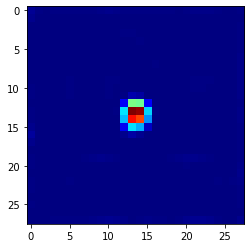

In [45]:
cam_o = cam_o_list[6]
cam_o = (cam_o - cam_o.min())/(cam_o.max()-cam_o.min())
cam_o_heatmap = cv2.applyColorMap(np.uint8(255*cam_o), cv2.COLORMAP_JET)
cam_o_heatmap = cv2.cvtColor(cam_o_heatmap, cv2.COLOR_BGR2RGB)
plt.imshow(cam_o_heatmap)

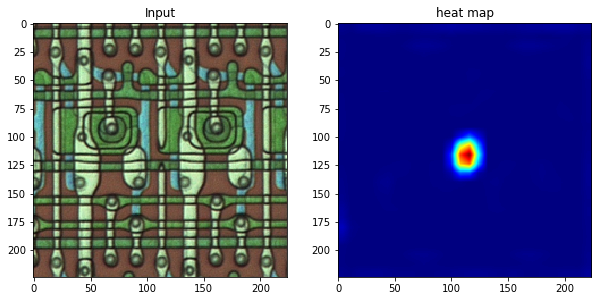

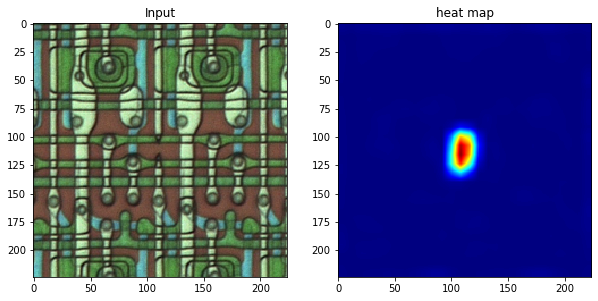

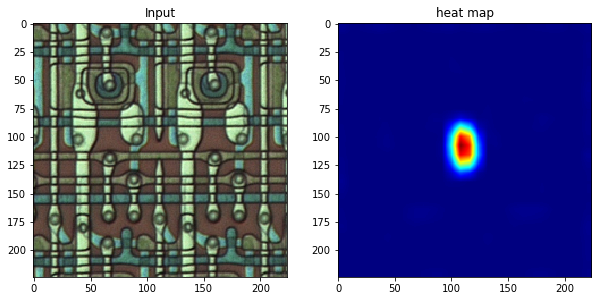

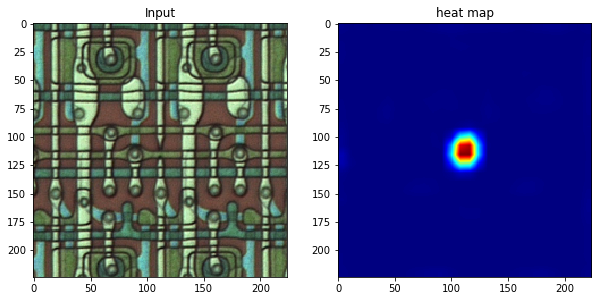

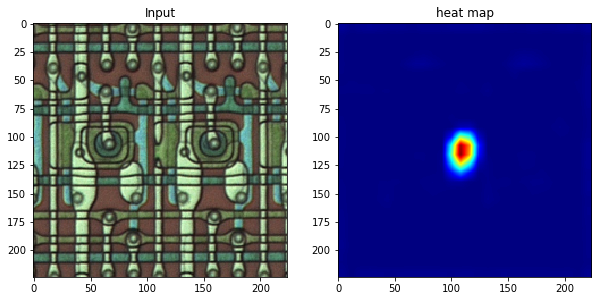

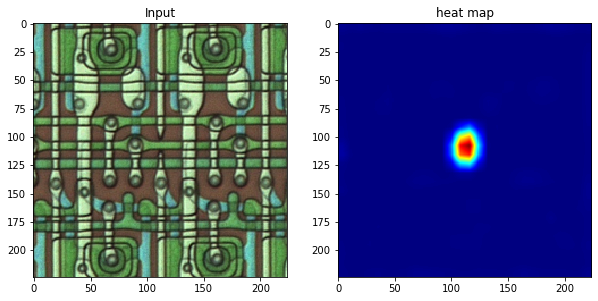

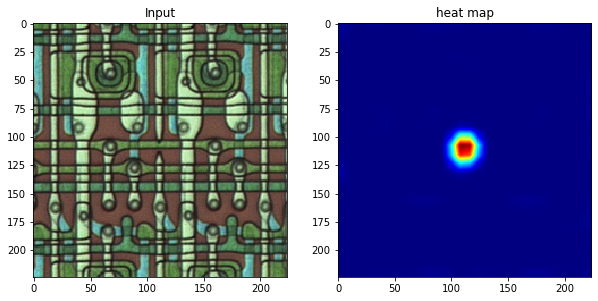

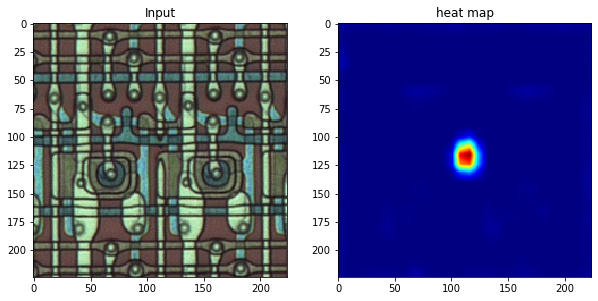

In [46]:
# Display images and Save
for i in range(num):
    temp = cv2.cvtColor(temp_img[i],cv2.COLOR_BGR2RGB)
    cam = cam_list[i]
    cam = (cam - cam.min())/(cam.max()-cam.min())
    cam_heatmap = cam_heatmap_list[i]
    guided_backprop = guided_backprop_list[i]
    guided_backprop_grad_cam = guided_backprop_grad_cam_list[i]
    
    fig = plt.figure(figsize=(10,10))
    ax_list = []
    for j in range(1,3):
        ax_list.append(fig.add_subplot(1, 2, j))
    
    ax_list[0].imshow(temp)#.astype(np.uint8))
    ax_list[0].set_title('Input')
    ax_list[1].imshow(cam_heatmap)
    ax_list[1].set_title('heat map')

#     plt.savefig('./result/BOE_B11/vgg_reduction_test_201120_1_modified_2_2/'+images_list[i]+'.png', transparent=True,bbox_inches='tight')
    cv2.imwrite('./result/BOE_B11/vgg_reduction_test_201120_1_modified_2_2/'+images_list[i]+'_cam.png', (cam*255).astype(np.uint8))
    cv2.imwrite('./result/BOE_B11/vgg_reduction_test_201120_1_modified_2_2/'+images_list[i]+'_input.png', cv2.cvtColor(temp, cv2.COLOR_RGB2BGR))
    plt.show()

(array([66, 66, 66], dtype=int64), array([1, 2, 7], dtype=int64))
(60, 224)
(60, 224)
42


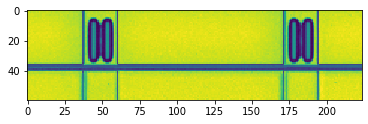

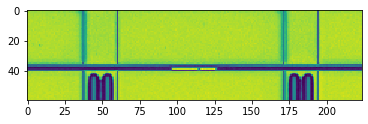

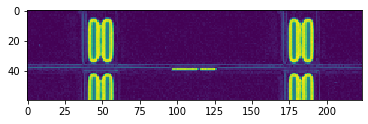

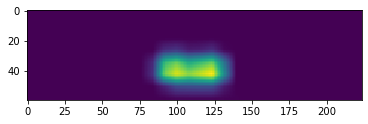

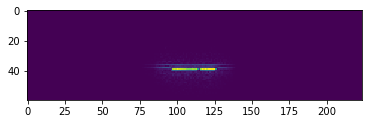

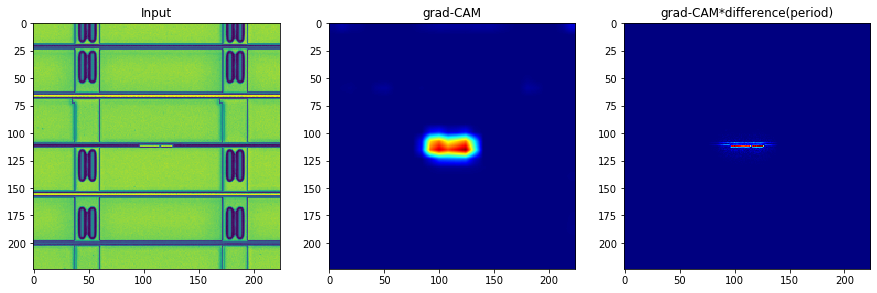

In [73]:
## manual tuning (temporal)
i = 5
temp = cv2.cvtColor(temp_img[i],cv2.COLOR_RGB2GRAY)
cam = cam_list[i]
cam = (cam - cam.min())/(cam.max()-cam.min())
cam_heatmap = cam_heatmap_list[i]
guided_backprop = guided_backprop_list[i]
guided_backprop_grad_cam = guided_backprop_grad_cam_list[i]
### 주기비교 ###

period = 89
height = 60
s_h = 73
s_h_p = s_h + period
test_temp = temp[s_h:s_h+height,:]
test_temp_p = temp[s_h_p:s_h_p+height]
test_cam = cam[s_h:s_h+height,:]
diff = cv2.absdiff(test_temp_p, test_temp)/255
diff_mul_cam = diff*test_cam
#diff_mul_cam = (diff_mul_cam-diff_mul_cam.min())/(diff_mul_cam.max() - diff_mul_cam.min())

plt.figure()
plt.imshow(test_temp_p)
plt.figure()
plt.imshow(test_temp)
plt.figure()
plt.imshow(diff)
plt.figure()
plt.imshow(test_cam)
plt.figure()
plt.imshow(diff_mul_cam)
print(np.where(temp == temp.max()))
cam_x_diff = np.zeros(np.shape(temp))
print(np.shape(cam_x_diff[s_h:s_h+height,:]))
print(np.shape(diff_mul_cam))
cam_x_diff[s_h:s_h+height,:] = diff_mul_cam
if cam_x_diff.max() >= 0.05:
    cam_x_diff = (cam_x_diff-cam_x_diff.min())/(cam_x_diff.max() - cam_x_diff.min())
cam_x_diff_rgb = cv2.applyColorMap(np.uint8(cam_x_diff*255), cv2.COLORMAP_JET)
cam_x_diff_rgb = cv2.cvtColor(cam_x_diff_rgb, cv2.COLOR_BGR2RGB)
################


fig = plt.figure(figsize=(15,10))
ax_list = []
for j in range(1,4):
    ax_list.append(fig.add_subplot(1, 3, j))

ax_list[0].imshow(temp)#.astype(np.uint8))
ax_list[0].set_title('Input')
ax_list[1].imshow(cam_heatmap)
ax_list[1].set_title('grad-CAM')    
ax_list[2].imshow(cam_x_diff_rgb)
ax_list[2].set_title('grad-CAM*difference(period)')

print(recon_.min())
#     ax_list[1].imshow(guided_backprop)
#     ax_list[1].set_title('guided backprop')
#     ax_list[2].imshow(guided_backprop_grad_cam)
#     ax_list[2].set_title('grad-CAM * gauided backprop')

plt.savefig('D:/Dataset/Checkpoint_vgg_16_1_lr0.00001_28x28_3/visualization_ep279/'+str(i)+'.png', transparent=True,bbox_inches='tight')
plt.show()

(array([101, 102, 102, 103, 103, 103, 103, 104, 104, 104, 104, 104, 104,
       105, 105, 105, 105, 105, 105, 106, 106, 106, 107, 107, 107, 108,
       108, 109, 110, 111, 112], dtype=int64), array([109, 108, 109, 111, 112, 113, 114, 108, 109, 112, 113, 114, 115,
       109, 110, 111, 112, 113, 115, 112, 113, 115, 113, 116, 117, 115,
       117, 105, 105, 117, 105], dtype=int64))


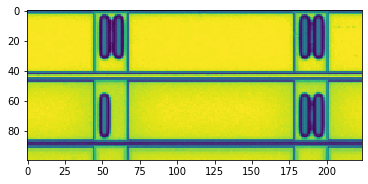

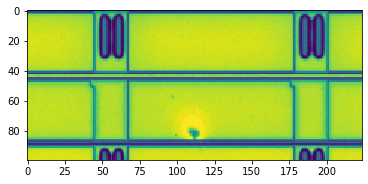

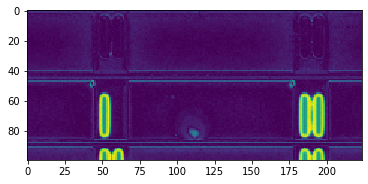

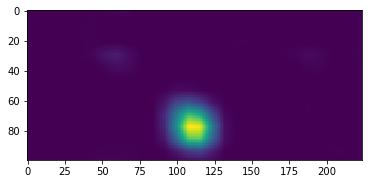

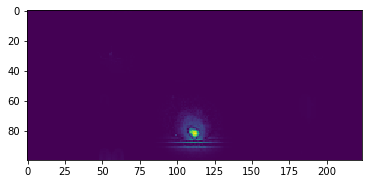

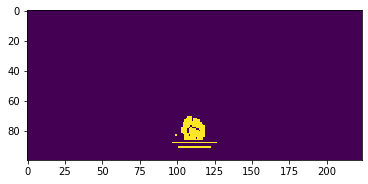

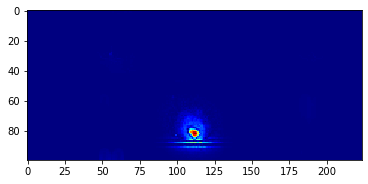

In [108]:
period = 89
height = 100
s_h = 30
s_h_p = s_h + period
test_temp = temp[s_h:s_h+height,:]
test_temp_p = temp[s_h_p:s_h_p+height]
test_cam = cam[s_h:s_h+height,:]
diff = cv2.absdiff(test_temp_p, test_temp)
diff_mul_cam = diff*test_cam
_, thresh = cv2.threshold(diff_mul_cam, 10, 255, cv2.THRESH_BINARY)
diff_mul_cam = (diff_mul_cam-diff_mul_cam.min())/(diff_mul_cam.max() - diff_mul_cam.min())
test_heatmap = cv2.applyColorMap(np.uint8(diff_mul_cam*255), cv2.COLORMAP_JET)
test_heatmap = cv2.cvtColor(test_heatmap, cv2.COLOR_BGR2RGB)
plt.figure()
plt.imshow(test_temp_p)
plt.figure()
plt.imshow(test_temp)
plt.figure()
plt.imshow(diff)
plt.figure()
plt.imshow(test_cam)
plt.figure()
plt.imshow(diff_mul_cam)
plt.figure()
plt.imshow(thresh)
plt.figure()
plt.imshow(test_heatmap)
print(np.where(temp == temp.max()))

In [18]:
# Contour를 찾아 가장 넓은 변적을 가지는 부분에 대하여 Bounding Box를 취함
heatmap = cam
threshold = 0.3
# Binarize the heatmap
_, thresh_heatmap = cv2.threshold(heatmap, threshold*heatmap.max(), 1, cv2.THRESH_BINARY)
# convert to uint8
thresh_heatmap = thresh_heatmap.astype(np.uint8)
# find contours
contours, _ = cv2.findContours(thresh_heatmap, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
print('number of contours:',len(contours))

number of contours: 7


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


NameError: name 'idx' is not defined

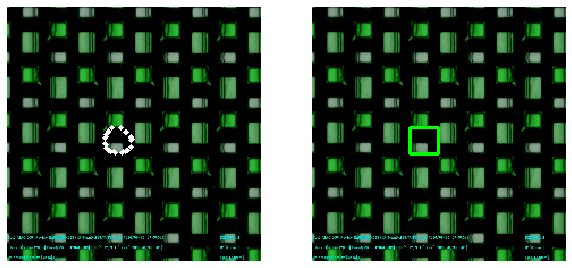

In [137]:
contour_areas = []   
for i, c in enumerate(contours):
    contour_areas.append(cv2.contourArea(c))

# contour 면적이 큰 순서대로 정렬
sorted_contours = sorted(zip(contour_areas, contours), key=lambda x:x[0], reverse=True)   

# # contour 면적이 큰 contours 선택
biggest_contour= sorted_contours[0][1]

# -1 : represent entire contours
# (255, 255, 255): color
# 3 : thinkness 
contour_image = cv2.drawContours(img.copy(), biggest_contour, -1, (255, 255, 255), 3)

# Draw bounding box
x,y,w,h = cv2.boundingRect(biggest_contour)
x,y,w,h
box_image = cv2.rectangle(img.copy(), (x,y), (x+w, y+h), (0, 255,0), 2)

fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)
ax1.imshow(contour_image)
ax2.imshow(box_image)
ax1.axis('off')
ax2.axis('off')
plt.savefig('D:/Dataset/Checkpoint_vgg_16_1_lr0.00001_28x28_3/visualization_ep279/bb_'+str(idx)+'.png', transparent=True,bbox_inches='tight')
plt.show()